# 保序回歸(Isotonic Regression)

##### 先引入我們需要的packages

In [5]:
import os 
import numpy as np
import random
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Training Data

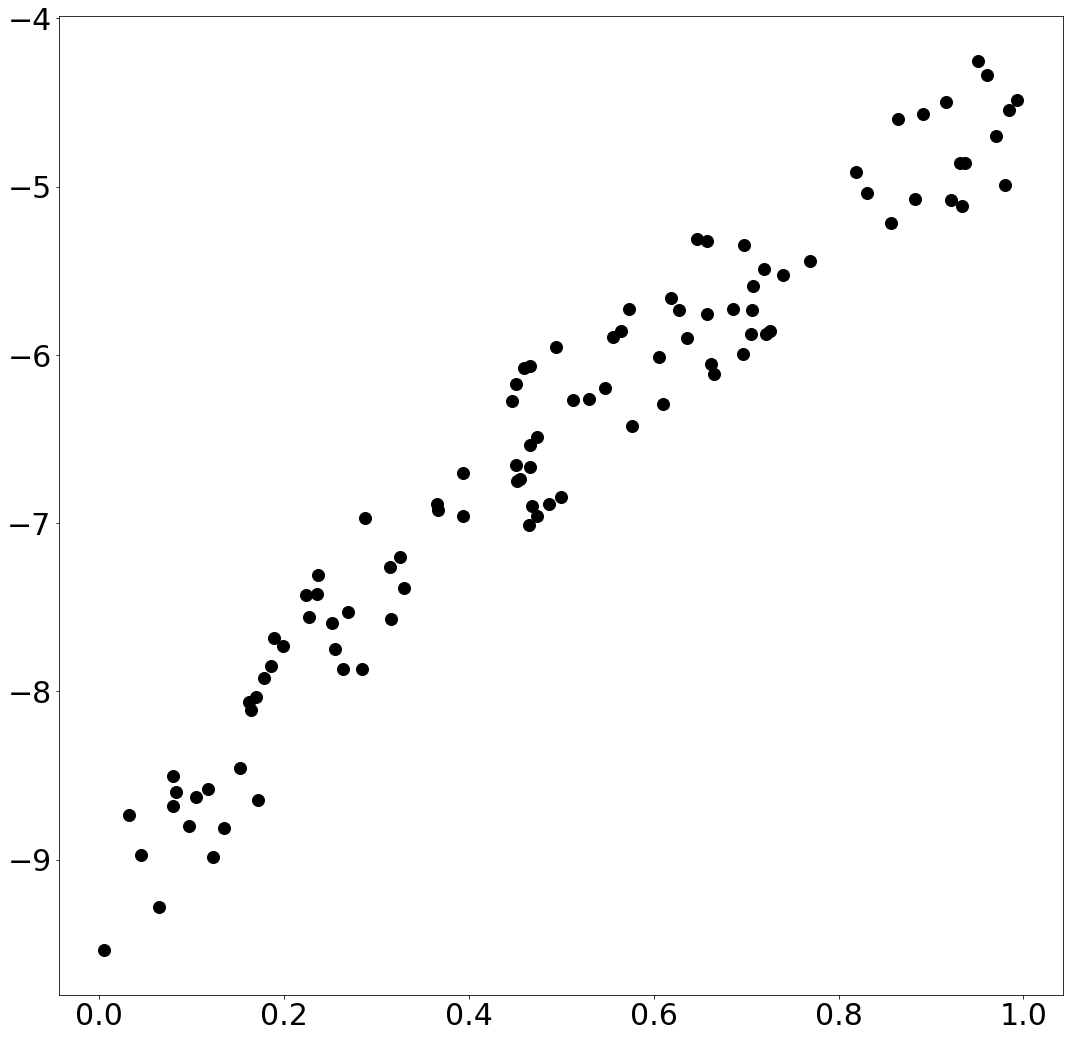

In [6]:
# p0~p9代表0次到9次方
p9,p8,p7,p6,p5,p4,p3,p2,p1,p0=1,-2,3,-4,5,-6,7,-8,9,-10
x=np.zeros(100)
y=np.zeros(100)
# 隨機產生數據點
for i in range(0,len(x)):
    x[i]+=random.random()
    y[i]+=random.random()*1
power=[p9,p8,p7,p6,p5,p4,p3,p2,p1,p0]
for i in range(0,len(power)):
    y+=power[len(power)-i-1]*(x**i)
# 視覺化
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Isotonic Regression

In [7]:
N=100
Q = cvxopt.matrix(np.diag(np.ones(N)))
p = cvxopt.matrix(-y[np.argsort(x)])
G = cvxopt.matrix((np.concatenate([np.diag(np.ones(N-1)),np.zeros((N-1,1))],axis=1)+
                                   np.concatenate([np.zeros((N-1,1)),np.diag(np.ones(N-1)*-1)],axis=1)))
h=cvxopt.matrix(np.zeros(N-1))
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['abstol'] = 1e-10
cvxopt.solvers.options['reltol'] = 1e-10
cvxopt.solvers.options['feastol'] = 1e-10
beta=np.array(cvxopt.solvers.qp(Q, p, G, h)['x']).flatten()

# Linear Regression

In [8]:
w=np.zeros(2)
x_mean=np.mean(x)
y_mean=np.mean(y)
x2_mean=np.mean(x**2)
xy_mean=np.mean(x*y)
a=1
for t in range(0,100):
    w[0]=w[0]-a*(w[0]+w[1]*x_mean-y_mean)
    w[1]=w[1]-a*(w[0]*x_mean+w[1]*x2_mean-xy_mean)

# Plot Together

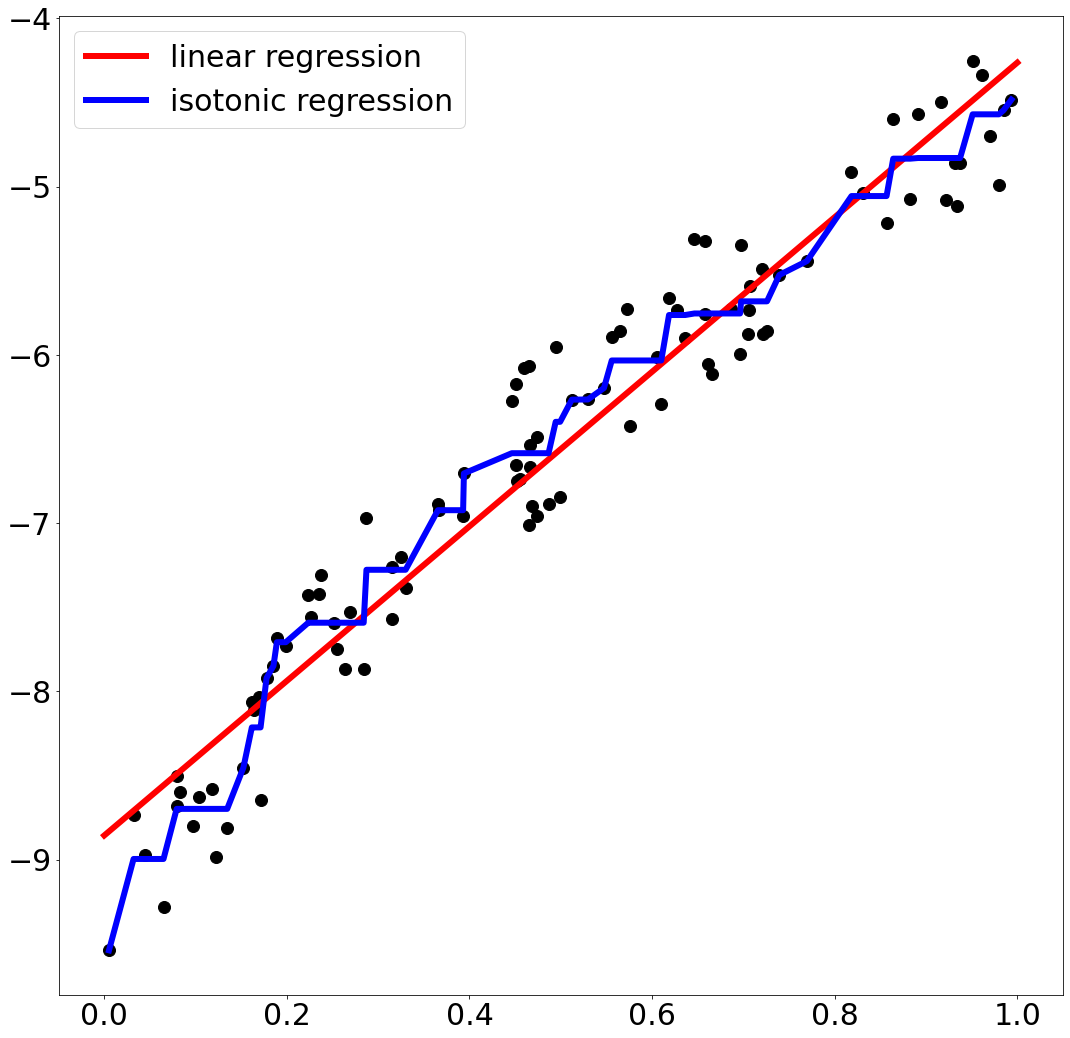

In [9]:
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=12)
plt.plot([0,1],[w[0],w[1]+w[0]],"r-",linewidth=6,label="linear regression")
plt.plot(np.sort(x),beta,"b-",linewidth=6,label="isotonic regression")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
plt.show()

# Apply on Ensemble Voting

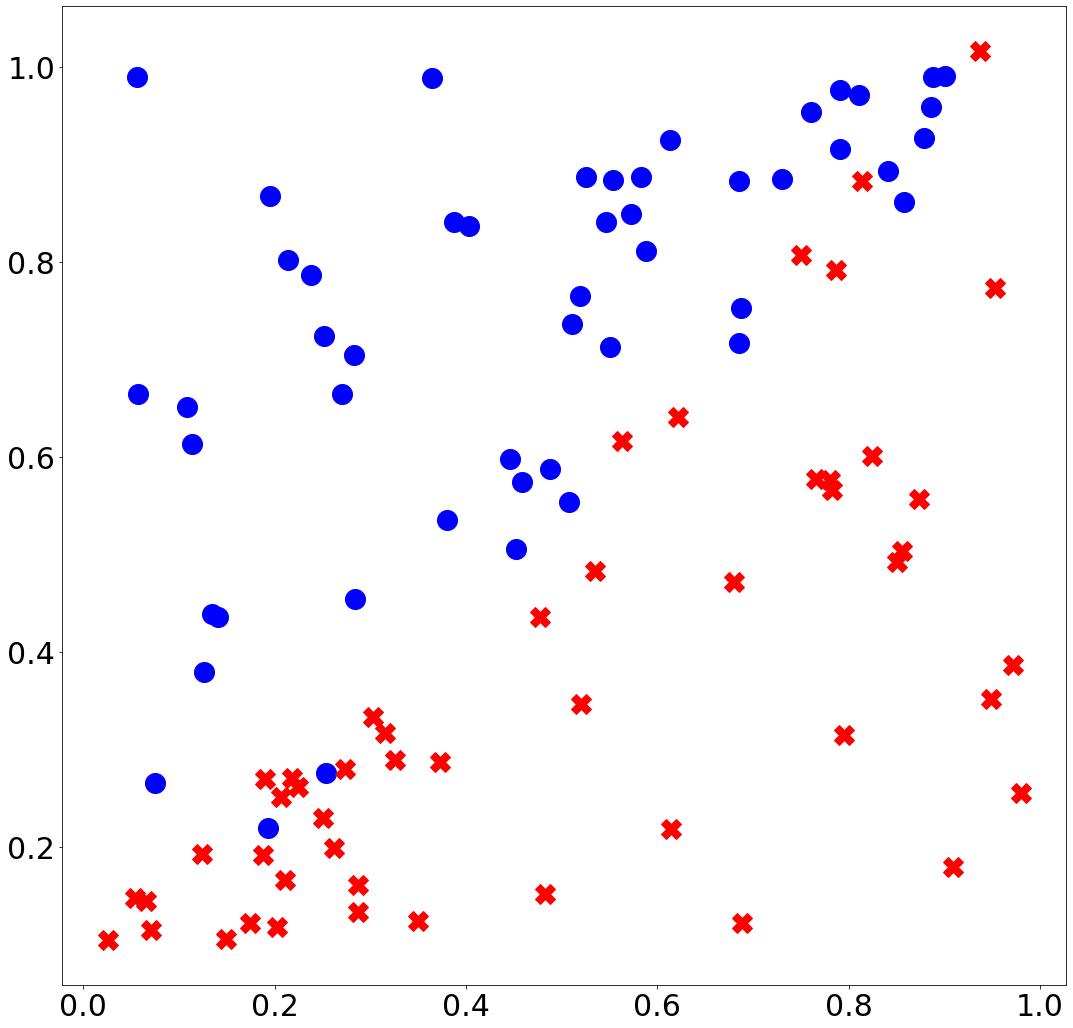

In [10]:
x=np.zeros((100,2))
y=np.zeros(100)
for i in range(0,100): 
    f=-0.1
    if(i<50):
        y[i]=1
        x[i,0]=random.random()
        x[i,1]=random.uniform(x[i,0],1)
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.uniform(0,x[i,0])-f
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x[:50,0],x[:50,1],"bo",markersize=20)
plt.plot(x[50:,0],x[50:,1],"rX",markersize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Polynomial Kernel

In [11]:
def Polynomial_kernel(x,xx,power,gamma,zeta):
    return (zeta+gamma*np.dot(x,xx.T))**power

# Support Vector Machine

In [12]:
def SVM(x,y,c,CC,gamma,zeta,N):
    Q = cvxopt.matrix((np.outer(y,y) * Polynomial_kernel(x,x,c,gamma,zeta)))
    p = cvxopt.matrix(np.ones(N)*-1.,(N,1))
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(N)* 1.),np.diag(np.ones(N)* -1.)])) 
    h = cvxopt.matrix(np.concatenate([CC*np.ones(N),np.zeros(N)]))
    A = cvxopt.matrix(y,(1,N))
    b = cvxopt.matrix(0.0)
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    a=np.array(cvxopt.solvers.qp(Q, p, G, h, A, b)['x']).flatten()
    SV=[]
    for i in range(0,N):
        if(a[i]>1e-6):
            SV.append(i)
    for sv in SV:
        if(y[sv]==1):
            s_u=sv
            break
    Com=0
    for i in range(0,N):
        Com+=y[i]*a[i]*Polynomial_kernel(x[i,:],x[s_u,:],c,gamma,zeta)
    b_u=y[s_u]-Com
    for sv in SV:
        if(y[sv]==-1):
            s_l=sv
            break
    Com=0
    for i in range(0,N):
        Com+=y[i]*a[i]*Polynomial_kernel(x[i,:],x[s_l,:],c,gamma,zeta)
    b_l=y[s_l]-Com
    return a,(b_u+b_l)/2

# Isotonic Regression Fitting 

In [13]:
def isotonic(f,y):
    N=len(y)
    Q = cvxopt.matrix(np.diag(np.ones(N)))
    p = cvxopt.matrix(-y[np.argsort(f)])
    G = cvxopt.matrix((np.concatenate([np.diag(np.ones(N-1)),np.zeros((N-1,1))],axis=1)+
                       np.concatenate([np.zeros((N-1,1)),np.diag(np.ones(N-1)*-1)],axis=1)))
    h=cvxopt.matrix(np.zeros(N-1))
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    beta=np.array(cvxopt.solvers.qp(Q, p, G, h)['x']).flatten()
    return beta,np.argsort(f)

# Using SVM as an Example

[ 9.99999638e-01  1.00000110e+00  9.99997818e-01  1.00000080e+00
  9.99994705e-01  9.99999349e-01  9.99999925e-01  5.00000000e-01
  9.99993960e-01  9.99997476e-01  5.00000000e-01  1.00000173e+00
  8.75000000e-01  8.75000000e-01  1.00000531e+00  9.99995316e-01
  5.00000000e-01  1.00000893e+00  1.00000613e+00  9.99988474e-01
  9.99991512e-01  1.00000021e+00  5.00000000e-01  1.00000050e+00
  1.00000279e+00  9.99998761e-01  8.75000000e-01  9.99999058e-01
  1.00001226e+00  8.75000000e-01  8.75000000e-01  9.99992981e-01
  1.00000141e+00  8.75000000e-01 -3.58170335e-08  1.00000206e+00
 -7.03653171e-06  1.00000411e+00  1.00000241e+00  8.75000000e-01
  9.99997115e-01  5.00000000e-01  1.00000319e+00  9.99996727e-01
  9.99996306e-01  1.00000362e+00  1.00000466e+00  5.00000000e-01
  1.25128530e-06  9.99998144e-01 -3.33432089e-06  9.99998457e-01
  1.53846154e-01  9.99995841e-01  1.00000724e+00 -1.21234049e-05
 -2.46247321e-06 -6.79024786e-07  6.86621201e-06  3.53357510e-06
 -3.83498910e-06 -1.70199

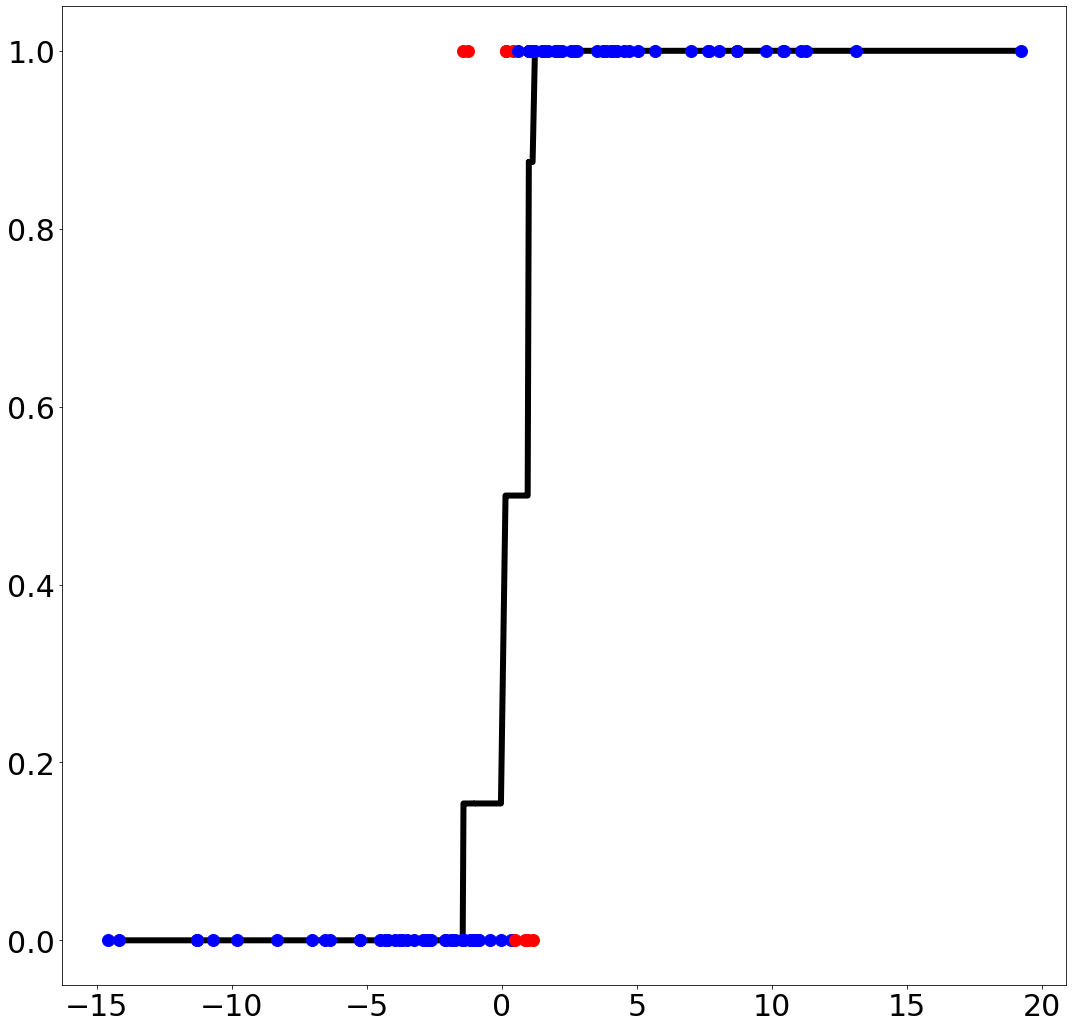

In [14]:
c=5
CC=100
gamma,zeta=1,1
a,b=SVM(x,y,c,CC,gamma,zeta,N)
f=np.dot(Polynomial_kernel(x,x,c,gamma,zeta),a*y)+b
t=np.ones(N)
t[50:]=np.zeros(50)
beta,index=isotonic(f,t)
print(beta[index])
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(np.sort(f),beta,"k-",linewidth=6)
for i in range(0,N):
    if(t[index[i]]==1):
        if(beta[i]>0.5):
            plt.plot(f[index[i]],t[index[i]],"bo",markersize=12)
        else:
            plt.plot(f[index[i]],t[index[i]],"ro",markersize=12)
    else:
        if(beta[i]<0.5):
            plt.plot(f[index[i]],t[index[i]],"bo",markersize=12)
        else:
            plt.plot(f[index[i]],t[index[i]],"ro",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()